<h1> NUMBER IDENTIFIER PROJECT </h1>
<h3> Started February 28, 2022 and completed March 3, 2022 </h3>

<p> The goal of this project is to train a neural network that can recognize the digits 0-9 </p>
<p> This machine learning project is based on the MNIST dataset, which are 28 pixel by 28 pixel black/white images of digits 0-9. </p>
<p> Uses pytorch library to gain access to operations that make programming a neural network easier and matplotlib to display results </p>


In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
from tqdm import tqdm

In [2]:
# Creating a dataset and dataloader for the MNIST dataset

def load_mnist(batch_size=32, train=True):

    to_tensor_transform = torchvision.transforms.ToTensor()
    
    
    dataset = torchvision.datasets.MNIST(r'C:\Users\surya\MNIST_intro_project\data', train, to_tensor_transform, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size)
    return dataset, dataloader

In [3]:
def plot_image_and_label(image, label):
    
    '''
    Takes in an image and label and shows them using matplotlib 
    this is used to visualize the data and also the outputs of our network
    '''

    plt.imshow(image)
    if type(label) is not int:
        _,predicted = torch.max(label,1)
        plt.title("Best label = " + str(predicted.item()) + ", with Score: " + str(round(label[0][predicted].item() * 100,2)))
    else:
        plt.title("Label = " + str(label))
    plt.show()
    return

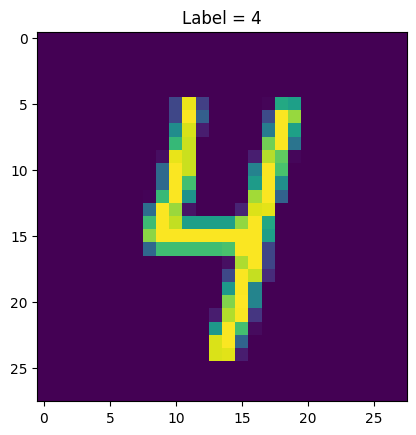

In [4]:
# A test to make sure the data loaded correctly

train_dataset, train_dataloader = load_mnist(batch_size=1, train=True)
ex_image, ex_label = train_dataset[random.randint(0,1000)]
plot_image_and_label(ex_image.reshape(28,28), ex_label)

Pytorch is built off of modules (called ```nn.Module```) which consist of 2 parts: The initialization (defined in ```__init__()``` -- note that this the python convention for initalizing classes) and the forward pass (defined aptly as ```forward()```)

One of the convenient features of Pytorch is that using these two features, the gradient can be found automatically - gradient descent will still need to be done, but most of the work will be done using the model() function. This saves a lot of time when doing the math.

The first attempt at making the model will revolve around a single-layer perceptron, which is a modifed neuron representing one matrix multiplication between inputs and a set of weights. It's result will be a row of 10 probabilities, where each one corresponds to the likelihood of the number in the picture bering one of the 10 digits. The highest probability digit will be what the model identifies the picture as.

Let's see how the single-layer perceptron does.







In [5]:
class MyPerceptron(nn.Module):

    def __init__(self, input_size, output_size):
        super(MyPerceptron, self).__init__()

        self.input_size = input_size

        self.lin = nn.Linear(input_size, output_size)


    def forward(self, x):

        x = x.view(-1, self.input_size)

        out = self.lin(x)

        return out

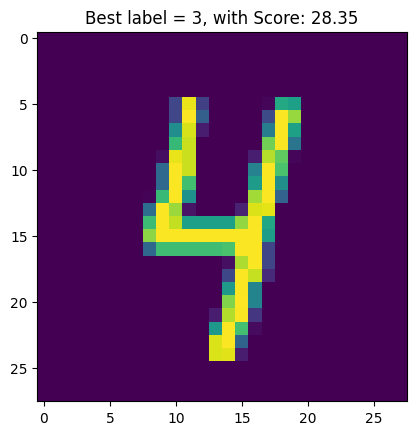

In [6]:
# This takes our randomly initialized perceptron and sees its prediction on a random input from MNIST
test_model = MyPerceptron(784, 10)
test_output = test_model(ex_image.flatten())

plot_image_and_label(ex_image.reshape(28,28), test_output)

This is clearly a wrong prediction, showing that one perceptron (one layer of neurons representing a matrix multiplication of input with weights) most likely won't be enough to satisfy what we are looking for. But how about a bigger-scale neural network with multiple layers of perceptrons?

Well, if we simply add mutiple linear layers, the result shouldn't change as much. Since perceptrons work with linear operations, combining perceptrons would combine all the linear processes into one - still a linear operation. So this is basically the same as working with one perceptron.

The way to notice the impact of having multiple layers is to have non-linear activation functions between each linear layer in the neural network/perceptron. More operations can be done with more weights, and modifying more weights can be helpful when trying to find more features that can help identify the digit correctly. It will also help the network with identifying relationships between variables that aren't neccesarily linear.

In [7]:
class MyMLP(nn.Module):


    def __init__(self, input_size, output_size):
        super(MyMLP, self).__init__()

        self.input_size = input_size # making the input size accessible

        self.lin1 = nn.Linear(input_size, 32)
        self.lin2 = nn.Linear(32, 16)
        self.lin3 = nn.Linear(16, output_size)

        self.relu = nn.ReLU() # Nonlinearity between layers, this makes the model be able to establish non-linear connections between variables.
         


    def forward(self, x):

        x = x.view(-1, self.input_size)   # This reshapes the input to work with the batches
 
        out = self.lin3(self.relu(self.lin2(self.relu(self.lin1(x))))) # Forward pass

        return out

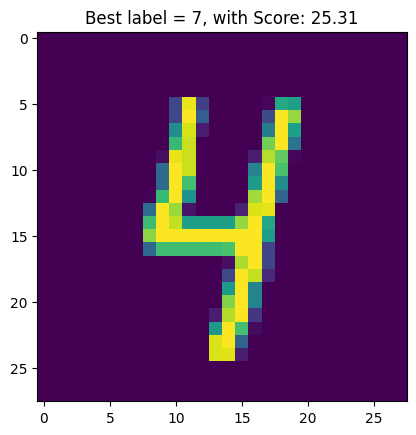

In [8]:
# Shows the prediction of the model without training
# Not very good huh? (though theres a small chance it is lol)

test_model = MyMLP(784, 10)
test_output = test_model(ex_image.flatten()) # Notice how we flatten the 2d image into 1d to use the MLP

plot_image_and_label(ex_image.reshape(28,28), test_output)

Still incorrect! The reason this model doesn't yet work as intended is because it hasn't been trained yet. The training will allow the model to learn from inputs and outputs, and find optimal weight matrices in the layers. Once the weights stop changing, this means that the model has found it's optimality, and the final pass through can be done to identify the digit correctly and with more confidence.

Optimality of a machine learning model is defined as minimizing a loss function. The lower the loss, the more accurate the model will be. Different loss functions can be used, and the model will perform differently based on which one is implemented. In this case, CrossEntropyLoss will be used, as it will automatically convert the losses into a 10-long vector, which is what we want, as the output of our neural network is a 10-long vector of probabilities. 

The training will be done through gradient descent, which updates the weights during the backpropogation step from the model's output/label/loss calculation back through the input, so the model can learn from the next piece of input-label data. 

While it would be nice to theoretically train until the gradient doesn't change, at this point which we know the loss should be at a minimum, this can take an infinitely long time. The gradient may not change much, but it will usually always change. So we repeat this backpropogation process for a certain number of epochs, which we can control. More epochs = more training = more accurate results, but also takes longer to train.

The below code tests gradient descent with our model using CrossEntropyLoss. The gradient should be negative, as this would indicate that our loss function is decreasing, which is what we want when training our neural network.

In [9]:
model = MyMLP(784, 10)                                        ## Model with input size 784 (28 by 28 images, with a 10-vector long output)

loss_function = nn.CrossEntropyLoss()                        
optimizer = torch.optim.SGD(model.parameters(),lr=0.02)     # Learning rate represents by what factor the weights should update per pass through. 
# Generally, lower learning rates are used, as we don't want to update our weights too much from just one piece of data (this is called underfitting)

# This checks that the model, loss and optimizer are valid
print("BEFORE GRADIENT STEP:")
ex_pred = model(ex_image.flatten())
print("prediction:",ex_pred)
ex_label = torch.Tensor([1]).long()
print("label:",ex_label)


optimizer.zero_grad() # Sets the gradient to 0 so that gradients don't stack together

ex_loss1 = loss_function(ex_pred, ex_label)
print("loss",ex_loss1.item())

ex_loss1.backward() # This gets the gradient of the loss function w.r.t all of the model's params

print()
print("AFTER GRADIENT STEP:")
optimizer.step() # This takes the step to train

ex_pred = model(ex_image.flatten())
print("prediction:",ex_pred)
ex_label = torch.Tensor([1]).long()
print("label:",ex_label)

ex_loss2 = loss_function(ex_pred, ex_label)
print("loss",ex_loss2.item())

print()
print("Difference in loss:", (ex_loss1 - ex_loss2).item())
print("This should be some positive number to say we reduced loss")


BEFORE GRADIENT STEP:
prediction: tensor([[-0.1721, -0.0490,  0.2129,  0.1559,  0.1247,  0.0978, -0.0407,  0.1126,
          0.1583,  0.1624]], grad_fn=<AddmmBackward0>)
label: tensor([1])
loss 2.434321165084839

AFTER GRADIENT STEP:
prediction: tensor([[-0.1632, -0.0068,  0.2187,  0.1618,  0.1070,  0.0835, -0.0415,  0.1171,
          0.1484,  0.1606]], grad_fn=<AddmmBackward0>)
label: tensor([1])
loss 2.3937602043151855

Difference in loss: 0.04056096076965332
This should be some positive number to say we reduced loss


In [10]:
# training function

def training(model, loss_function, optimizer, train_dataloader, n_epochs, update_interval):

    '''
    Updates the parameters of the given model using the optimizer of choice to
    reduce the given loss_function

    This will iterate over the dataloader 'n_epochs' times training on each batch of images
    
    To get the gradient (which is stored internally in the model) .backward() from the loss tensor is used, and for it to be applied
    .step() is used on the optimizer

    In between steps the gradient is zeroed so it isn't accidentally reused for the next iteration
    '''
    
    losses = []

    for n in range(n_epochs):
        for i, (image, label) in enumerate(tqdm(iter(train_dataloader))):

            optimizer.zero_grad()
            my_output = model(image)
            loss = loss_function(my_output, label)

            loss.backward()
            optimizer.step()
        
            if i % update_interval == 0:
                losses.append(round(loss.item(), 2)) # This will append your losses for plotting -- please use "loss" as the name for your loss
        
    return model, losses



  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:12<00:00, 74.89it/s]


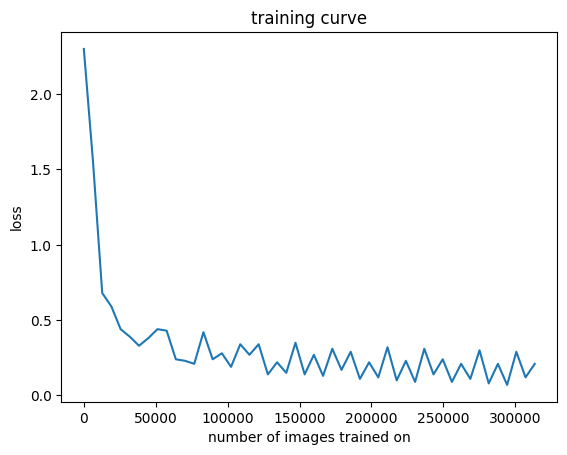

In [15]:
# Hyperparameter tuning

lr = 0.06               # The size of the step taken when doing gradient descent - initially 0.02
batch_size = 64         # The number of images being trained on at once - initially 128
update_interval = 100   # The number of batches trained on before recording loss - initially 100
n_epochs = 5           # The number of times we train through the entire dataset

train_dataset, train_dataloader = load_mnist(batch_size=batch_size, train=True)

model = MyMLP(784, 10)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

trained_model, losses = training(model, loss_function, optimizer, train_dataloader, n_epochs=n_epochs, update_interval=update_interval)

plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses)
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()


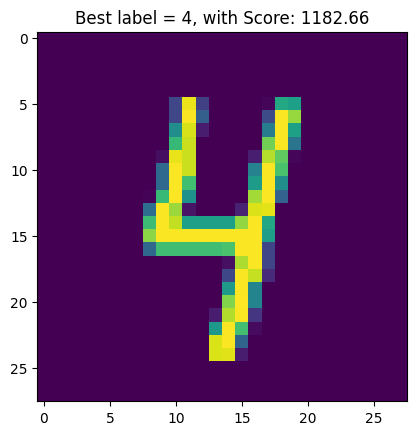

In [16]:
trained_output = trained_model(ex_image.flatten())

plot_image_and_label(ex_image.reshape(28,28), trained_output)

The number is correctly identified, and the score is high, showing that the model is very confident that its answer is correct! However, to show that the model isn't just fit to this training example, and the rest of the training data, we will have to test it. 

The testing process is the same as training, except test accuracy and average loss are also calculated.

In [17]:
def testing(model, loss_function, test_data):

    '''
    This function will test the given model on the given test_data
    it will return the accuracy and the test loss (given by loss_function) 
    '''
    
    sum_loss = 0
    n_correct = 0
    total = 0

    for i, (image, label) in enumerate(tqdm(iter(test_data))):

        pred = model(image)
        loss = loss_function(pred, label)
        sum_loss += loss.item()

        _, predicted = torch.max(pred,1)
        n_correct += (predicted == label).sum()
        total += label.size(0)
    
    test_acc = round(((n_correct / total).item() * 100), 2)
    avg_loss = round(sum_loss / len(test_data), 2)

    print("test accuracy:", test_acc)
    print("test loss:", avg_loss )

    return test_acc, avg_loss


print("testing the previously trained model on test dataset of MNIST")
test_dataset, test_dataloader = load_mnist(batch_size=10000, train=False)
_,_ = testing(trained_model, loss_function, test_dataloader)

testing the previously trained model on test dataset of MNIST


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

test accuracy: 94.81
test loss: 0.18


In [18]:
def train_and_test(model, loss_function, optimizer, batch_size, update_interval, n_epochs):

    _, train_dataloader = load_mnist(batch_size=batch_size, train=True)
    trained_model, losses = training(model, loss_function, optimizer, train_dataloader, n_epochs=n_epochs, update_interval=update_interval)

    _, test_dataloader = load_mnist(batch_size=10000, train=False)
    test_acc, test_loss = testing(trained_model, loss_function, test_dataloader)

    plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses, color="b", label="train loss")
    plt.hlines(test_loss, 0, len(losses) * batch_size * update_interval, color='r', label="test loss")
    plt.legend()
    plt.title("training curve")
    plt.xlabel("number of images trained on")
    plt.ylabel("loss")
    plt.show()

    return trained_model, test_loss

    

  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

test accuracy: 95.18
test loss: 0.16


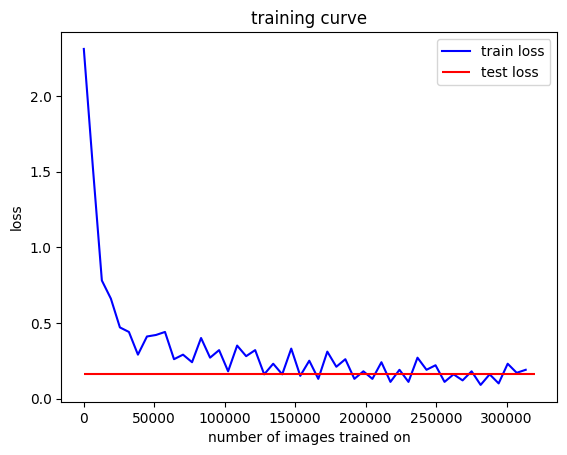

In [19]:
# Hyperparameter tuning

lr = 0.06               # The size of the step taken when doing gradient descent
batch_size = 64        # The number of images being trained on at once
update_interval = 100   # The number of batches trained on before recording loss
n_epochs = 5            # The number of times we train through the entire dataset

model = MyMLP(784, 10)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

_, _ = train_and_test(model, loss_function, optimizer, batch_size=batch_size, update_interval=update_interval, n_epochs=n_epochs)

The testing loss ends up being about the same as the training loss, showing that the model is not overfit - it is accurate with both training and testing data.

Instead of working with perceptrons (linear layers), we will train with the same dataset through a Convolutional Neural Network, which consists of convolutional layers instead of linear layers.

A convolutional layer consists of a kernel with a defined size and a specified number of filters. Overlapping the kernel with the input data matrix will yield a matrix smaller in size, and the data is spread out through these filters. Using this process, the filters are able to extract certain features of the data. In the case of identifying digits, this could be determining if there are rounded edges, straight edges.

The same process of creating, training, and testing a multi-layer perceptron is used for the CNN. 

In [20]:
class MyCNN(nn.Module):

    def __init__(self, input_size, output_size):
        super(MyCNN, self).__init__()

        self.input_size = input_size # making the input size accessible - for MNIST, this will be 28 * 28 * 1

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.conv2 = torch.nn.Conv2d(in_channels=10, out_channels=2, kernel_size=3, stride=1, padding=0)

        self.relu = nn.ReLU() 
        
        cnn_out_size = 24*24*2      # The final size of the output after the convolutional layers - calculated by hand.
        # For each convolutional operation, output_width = (input_width + 2 * padding - kernel_size) / stride + 1

        self.mlp = MyMLP(cnn_out_size, output_size)


    def forward(self, x):

        x = x.view(-1, 1, 28, 28)   # This reshapes the input to work with the batches

        out = self.conv2(self.relu(self.conv1(x)))

        self.filtered = out
        out = out.flatten()
        out = self.mlp(out)  

        return out

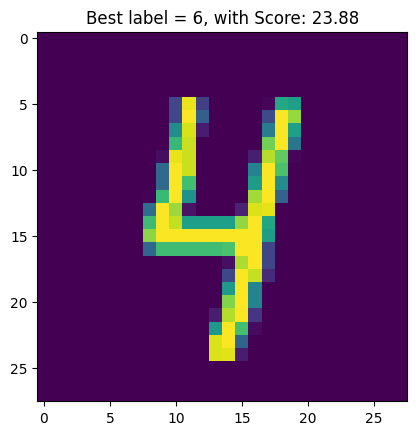

In [21]:
# This will show the output of our model before training

test_model = MyCNN(784, 10)
test_output = test_model(ex_image)

plot_image_and_label(ex_image.reshape(28,28), test_output)

Training and testing the CNN, with hyperparameter tuning.

  0%|          | 0/469 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


test accuracy: 96.16
test loss: 0.16


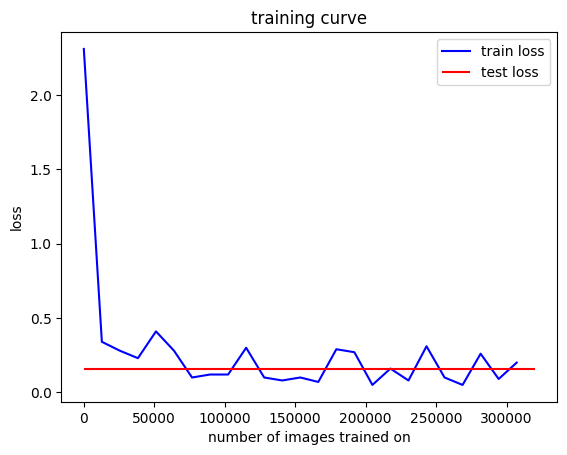

In [22]:
lr = 0.02               # The size of the step taken when doing gradient descent
batch_size = 128        # The number of images being trained on at once
update_interval = 100   # The number of batches trained on before recording loss
n_epochs = 5            # The number of times we train through the entire dataset

model = MyCNN(784, 10)                                          # CNN Model
loss_function = nn.CrossEntropyLoss()                           
optimizer = torch.optim.Adam(model.parameters(), lr=lr)        # This is an improved version of SGD which decreases the learning rate over time to avoid leaving a minima

trained_model, _ = train_and_test(model, loss_function, optimizer, batch_size=batch_size, update_interval=update_interval, n_epochs=n_epochs)

The test accuracy is higher for the CNN compared to the multi-layer perceptron (MLP), and the test loss is lower, suggesting that the CNN model may be better for this data than a MLP. With a more powerful system, both the CNN and the MLP can be made more powerful to improve performance and test results.

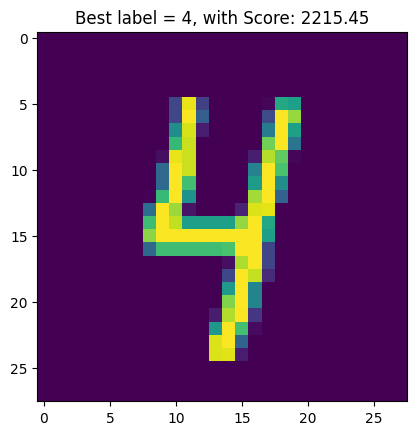

In [23]:
test_output = trained_model(ex_image)

plot_image_and_label(ex_image.reshape(28,28), test_output)

In [24]:
def display_filters(params, name):

    fig = plt.figure(figsize=(10, 7))

    rows = len(params)//5 + 1

    for i,filter in enumerate(params):
        fig.add_subplot(rows, 5, i+1)
        plt.imshow(filter)
        plt.axis('off')
        plt.title(name + "filter #"+str(i))
    
    plt.show

The following is a visualization of what each of the final output filters look like. The number of filters is equal to the out_channels value of the last conv2d layer (in the creation class of the model). Each filter extract some features of the data. From the below images, it seems that the first filter keeps track of vertical lines, as the blue-ish vertical lines are distinct from the rest of the image. By similar logic, the second filter seems to keep track of both vertical and horizontal lines of the digit. 

With more filters, more features can be extracted. This, however, does cause the model to train for longer.

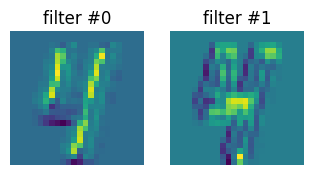

In [25]:
# The number of filters is determined by the out_channels value of the last conv2d layer -> there are 2 filters

filtered = model.filtered[0].detach().numpy()
display_filters(filtered, "")
